### このコードではMNISTデータセットを使って，手書き数字を認識するモデルを作ります

# 今週の内容
- モデル
- 損失関数，最適化手法
- 学習，テスト用関数
- 学習と評価
- *結果をグラフで確認*

# ライブラリ

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

# デバイス指定

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 確認
print(device)

cpu


# ハイパーパラメータ

In [3]:
batch_size = 64
learning_rate = 0.01
num_epochs = 10

# データセット

In [4]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform = transforms.ToTensor()
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 55.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.59MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.70MB/s]


# モデル定義

In [5]:
class Model(nn.Module): # nn.Moduleを継承したクラスを作成
    # モデルの構造を定義
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1)
        )

    # 順方向の計算．入力データをどのようにモデルに通していくかを定義
    def forward(self, x: torch.Tensor):
        x = x.view(-1, 28*28) # 28x28の2次元データを1次元に変換する
        x = self.model(x) # __init__で定義したモデルに通して計算
        return x

model = Model()
model.to(device)

Model(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

# 損失関数＆最適化アルゴリズム

In [6]:
criterion = nn.NLLLoss() # Negative Log Likelihood
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 学習用関数

In [7]:
def train_model(model, train_loader, optimizer, epoch, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += images.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total

    print(f'Epoch {epoch+1} / {num_epochs}')
    print(f'訓練セット: 損失: {avg_loss:<8.4f}, 精度: {accuracy:.2f}%')

    return avg_loss, accuracy

# テスト用関数

In [8]:
def test_model(model, test_loader, criterion):
    model.eval() # モデルを評価モード切り替え
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            test_loss += criterion(outputs, target).item()
            predicted = outputs.argmax(dim=1, keepdim=True)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'テストセット: 損失: {test_loss:.4f}, 精度: {correct} / {len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return test_loss, accuracy

# 学習と評価

In [9]:
train_losses = list()
train_accuracy = list()
test_losses = list()
test_accuracy = list()

for epoch in range(num_epochs):
    avg_loss, accuracy = train_model(model, train_loader, optimizer, epoch, criterion)
    train_losses.append(avg_loss)
    train_accuracy.append(accuracy)

    test_loss, accuracy = test_model(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accuracy.append(accuracy)

100%|██████████| 938/938 [00:12<00:00, 72.64it/s]


Epoch 1 / 10
訓練セット: 損失: 1.6427  , 精度: 63.62%
テストセット: 損失: 0.7120, 精度: 69436 / 10000 (694.36%)



100%|██████████| 938/938 [00:12<00:00, 76.73it/s]


Epoch 2 / 10
訓練セット: 損失: 0.5313  , 精度: 85.87%
テストセット: 損失: 0.4062, 精度: 69785 / 10000 (697.85%)



100%|██████████| 938/938 [00:12<00:00, 74.41it/s]


Epoch 3 / 10
訓練セット: 損失: 0.3846  , 精度: 89.23%
テストセット: 損失: 0.3361, 精度: 69932 / 10000 (699.32%)



100%|██████████| 938/938 [00:15<00:00, 60.42it/s]


Epoch 4 / 10
訓練セット: 損失: 0.3341  , 精度: 90.50%
テストセット: 損失: 0.3044, 精度: 70007 / 10000 (700.07%)



100%|██████████| 938/938 [00:12<00:00, 74.88it/s]


Epoch 5 / 10
訓練セット: 損失: 0.3038  , 精度: 91.32%
テストセット: 損失: 0.2777, 精度: 70138 / 10000 (701.38%)



100%|██████████| 938/938 [00:12<00:00, 75.48it/s]


Epoch 6 / 10
訓練セット: 損失: 0.2810  , 精度: 91.88%
テストセット: 損失: 0.2605, 精度: 70210 / 10000 (702.10%)



100%|██████████| 938/938 [00:13<00:00, 71.08it/s]


Epoch 7 / 10
訓練セット: 損失: 0.2617  , 精度: 92.48%
テストセット: 損失: 0.2459, 精度: 70193 / 10000 (701.93%)



100%|██████████| 938/938 [00:12<00:00, 76.10it/s]


Epoch 8 / 10
訓練セット: 損失: 0.2448  , 精度: 92.95%
テストセット: 損失: 0.2320, 精度: 70233 / 10000 (702.33%)



100%|██████████| 938/938 [00:12<00:00, 75.15it/s]


Epoch 9 / 10
訓練セット: 損失: 0.2298  , 精度: 93.43%
テストセット: 損失: 0.2157, 精度: 70291 / 10000 (702.91%)



100%|██████████| 938/938 [00:12<00:00, 75.82it/s]


Epoch 10 / 10
訓練セット: 損失: 0.2160  , 精度: 93.87%
テストセット: 損失: 0.2068, 精度: 70347 / 10000 (703.47%)



# グラフ化

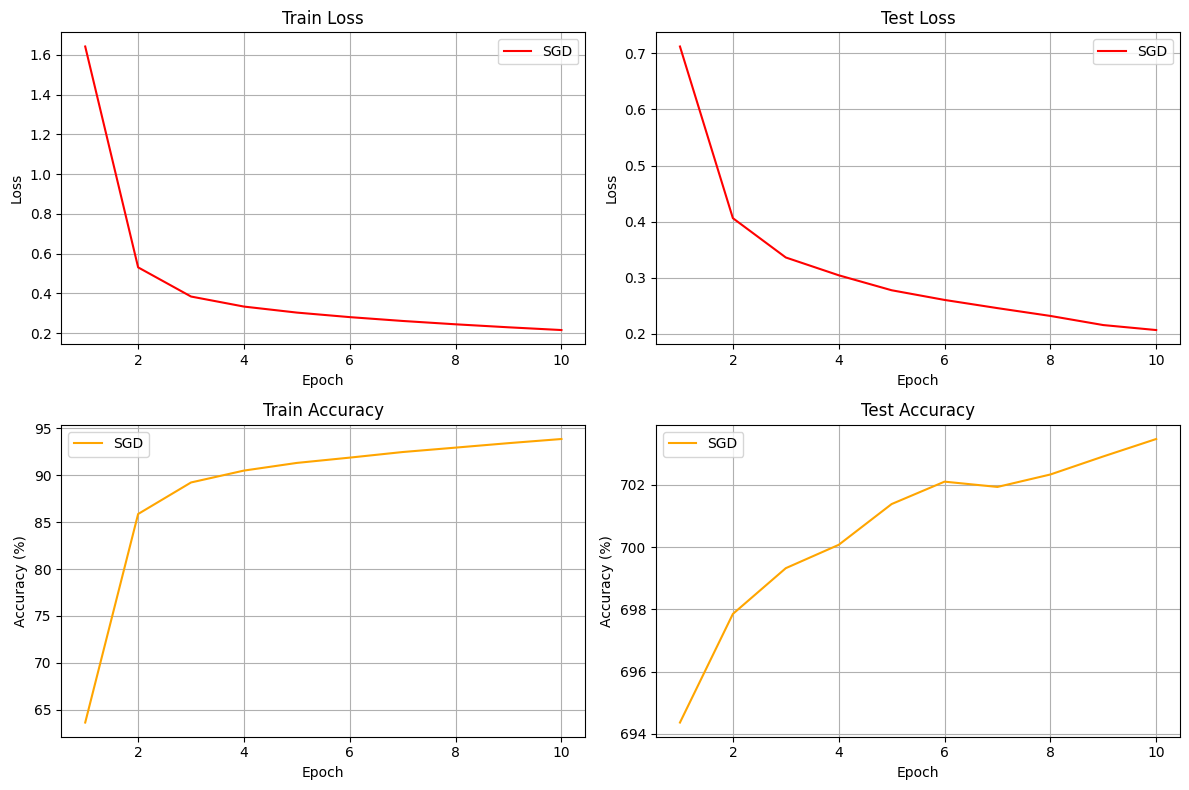

In [10]:
plt.figure(figsize=(12, 8))

# ---- 損失（訓練）----
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='SGD', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.grid(True)

# ---- 損失（テスト）----
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), test_losses, label='SGD', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.grid(True)

# ---- 精度（訓練）----
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), train_accuracy, label='SGD', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy')
plt.legend()
plt.grid(True)

# ---- 精度（テスト）----
plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs + 1), test_accuracy, label='SGD', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()